<a href="https://colab.research.google.com/github/KeaganChasenski/PDF_EXCEL_reading_Daysheet/blob/main/Skukuzas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pdfplumber
!pip install pandas
!pip install matplotlib
!pip install openpyxl
!pip install xlrd

In [2]:
import logging
import pdfplumber
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import re

from IPython import get_ipython
from IPython.display import display

In [3]:
from google.colab import drive
drive.mount('/content/drive')
excel_folder_path = '/content/drive/MyDrive/Daysheets'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Code for reading in Excel Docs


In [57]:
# --- Data Reading from Excel Folder Structure ---

excel_folder_path = '/content/drive/MyDrive/Daysheets'
all_data = {}

try:
    # Get list of year folders
    year_folders = [f for f in os.listdir(excel_folder_path) if os.path.isdir(os.path.join(excel_folder_path, f))]

    for year_folder in year_folders:
        year_path = os.path.join(excel_folder_path, year_folder)
        print(f"Processing year folder: {year_path}")

        # Get list of month files in the year folder
        month_files = [f for f in os.listdir(year_path) if os.path.isfile(os.path.join(year_path, f)) and f.endswith('.xlsx')]

        for month_file in month_files:
            excel_file_path = os.path.join(year_path, month_file)
            print(f"  Processing month file: {excel_file_path}")

            try:
                excel_file = pd.ExcelFile(excel_file_path)
                sheet_names = excel_file.sheet_names

                for sheet_name in sheet_names:
                    try:
                        df = excel_file.parse(sheet_name, header=None)
                        date_str = sheet_name

                        # Convert the DataFrame to a list of lists
                        tables_list = [df.values.tolist()]

                        # Use a unique key for each sheet from each file, e.g., "Year_Month_SheetName"
                        unique_key = f"{year_folder}_{month_file}_{sheet_name}"
                        all_data[unique_key] = {"date": date_str, "tables": tables_list}

                    except Exception as e:
                        print(f"Error processing sheet {sheet_name} in file {excel_file_path}: {e}")

            except FileNotFoundError:
                print(f"Error: Excel file not found at {excel_file_path}")
            except Exception as e:
                print(f"Error opening or reading Excel file {excel_file_path}: {e}")

except Exception as e:
    print(f"Error processing main folder {excel_folder_path}: {e}")

print("------ DONE -------")

Processing year folder: /content/drive/MyDrive/Daysheets/2023
  Processing month file: /content/drive/MyDrive/Daysheets/2023/February 2023.xlsx
  Processing month file: /content/drive/MyDrive/Daysheets/2023/May 2023.xlsx
  Processing month file: /content/drive/MyDrive/Daysheets/2023/July 2023.xlsx
  Processing month file: /content/drive/MyDrive/Daysheets/2023/October 2023.xlsx
  Processing month file: /content/drive/MyDrive/Daysheets/2023/January 2023.xlsx
  Processing month file: /content/drive/MyDrive/Daysheets/2023/December 2023.xlsx
  Processing month file: /content/drive/MyDrive/Daysheets/2023/March 2023.xlsx
  Processing month file: /content/drive/MyDrive/Daysheets/2023/ September 2023.xlsx
  Processing month file: /content/drive/MyDrive/Daysheets/2023/August 2023.xlsx
  Processing month file: /content/drive/MyDrive/Daysheets/2023/November 2023.xlsx
  Processing month file: /content/drive/MyDrive/Daysheets/2023/April 2023.xlsx
  Processing month file: /content/drive/MyDrive/Daysh

In [58]:
# --- SLT Counting ---

slt_counts = {}

for sheet_name, data in all_data.items():
    file_date = data.get("date")

    file_tables = data.get("tables")
    #print(f"Processing data from {file_date}:")

    slt_counts[sheet_name] = {}

    for i, table in enumerate(file_tables):

      df = pd.DataFrame(table)

      # Count 'SLT' in column 9 (index 8) for arrivals and column 22 (index 21) for departures
      arrival_count = 0
      depart_count = 0

      # Ensure columns exist before attempting to access them
      if len(df.columns) > 8:
          arrival_count = df[df.columns[8]].astype(str).str.lower().str.count('slt').sum()
      else:
          print(f"Column 9 (index 8) not found in sheet {sheet_name}.")


      if len(df.columns) > 21:
          depart_count = df[df.columns[21]].astype(str).str.lower().str.count('slt').sum()
      else:
          print(f"Column 22 (index 20) not found in sheet {sheet_name}.")


      # Store the counts for this specific table (sheet)
      slt_counts[sheet_name][f"sheet_{i+1}"] = {
                      "arrival_count": int(arrival_count),
                      "depart_count": int(depart_count)
                    }

      #print(f"Number of rooms on and SLT for {file_date} - Arrivals: {arrival_count}, Departures: {depart_count}")

print("-------- DONE --------")
#print("\n--- Final SLT Counts ---")
#for sheet_name, tables_data in slt_counts.items():
 #print(f"Sheet: {sheet_name}")
  #for table_name, counts in tables_data.items():
    #print(f"   Arrivals = {counts['arrival_count']}, Departures= {counts['depart_count']}")

In [60]:
# --- Calculate Total Daily Counts and Averages ---

def remove_day_suffix(date_string):
    return re.sub(r'(\d+)(st|nd|rd|th)', r'\1', date_string)

daily_total_counts = {}

for sheet_name, data in all_data.items():
    total_arrivals_for_day = 0
    total_departures_for_day = 0

    # Access the tables data specifically for the current sheet
    file_tables = data.get("tables")

    if file_tables:
        # Assuming each sheet's 'tables' is a list of DataFrames or similar structures
        # Re-calculate the SLT counts for the current sheet here.
        # Get the SLT counts for this sheet
        current_slt_counts = slt_counts.get(sheet_name, {})

        for table_name, counts in current_slt_counts.items():
             total_arrivals_for_day += counts.get("arrival_count", 0)
             total_departures_for_day += counts.get("depart_count", 0)


    date_str = data.get("date") # Get the date string from the current sheet's data

    if date_str:
        try:
            # Remove leading/trailing whitespace
            date_str = date_str.strip()

            # Remove the day suffix before parsing
            date_str_cleaned = remove_day_suffix(date_str)

            # Attempt to parse the cleaned date string
            file_date_obj = datetime.strptime(date_str_cleaned, '%A %d %B %Y')

            daily_total_counts[file_date_obj] = {
                "total_arrival_count": total_arrivals_for_day,
                "total_depart_count": total_departures_for_day
            }

        except ValueError as e:
            print(f"Could not parse date string '{date_str}' from sheet {sheet_name}: {e}")
        except Exception as e:
            print(f"An unexpected error occurred during date parsing for {sheet_name}: {e}")
    else:
         print(f"Date not found in all_data for sheet {sheet_name}")
print("-------- DONE --------")

Could not parse date string '' from sheet 2023_October 2023.xlsx_ : time data '' does not match format '%A %d %B %Y'
Could not parse date string '' from sheet 2023_December 2023.xlsx_ : time data '' does not match format '%A %d %B %Y'
Could not parse date string '' from sheet 2023_ September 2023.xlsx_ : time data '' does not match format '%A %d %B %Y'
Could not parse date string 'Wednesday 13th September' from sheet 2023_ September 2023.xlsx_Wednesday 13th September : time data 'Wednesday 13 September' does not match format '%A %d %B %Y'
Could not parse date string '' from sheet 2023_August 2023.xlsx_ : time data '' does not match format '%A %d %B %Y'
Could not parse date string '' from sheet 2023_November 2023.xlsx_ : time data '' does not match format '%A %d %B %Y'
Could not parse date string 'Sunday  19th November' from sheet 2023_November 2023.xlsx_Sunday  19th November : time data 'Sunday  19 November' does not match format '%A %d %B %Y'
Could not parse date string '1st Tuesday J

In [27]:
# --- Calculate Average Counts Per Month ---
monthly_aggregated_counts = {}

for date_obj, counts in daily_total_counts.items():
    month_year_key = date_obj.strftime('%Y-%m')

    if month_year_key not in monthly_aggregated_counts:
        monthly_aggregated_counts[month_year_key] = {
            "total_arrivals": 0,
            "total_departures": 0,
            "number_of_days": 0
        }

    monthly_aggregated_counts[month_year_key]["total_arrivals"] += counts["total_arrival_count"]
    monthly_aggregated_counts[month_year_key]["total_departures"] += counts["total_depart_count"]
    monthly_aggregated_counts[month_year_key]["number_of_days"] += 1

monthly_average_counts = {}

for month_year_key, totals in monthly_aggregated_counts.items():
    num_days = totals["number_of_days"]
    if num_days > 0:
        avg_arrivals = totals["total_arrivals"] / num_days
        avg_departures = totals["total_departures"] / num_days
        monthly_average_counts[month_year_key] = {
            "average_arrivals": avg_arrivals,
            "average_departures": avg_departures
        }
    else:
        monthly_average_counts[month_year_key] = {
            "average_arrivals": 0,
            "average_departures": 0
        }
print("-------- DONE --------")

In [28]:
# --- Calculate Average Counts Per Year (for each year) ---

yearly_aggregated_counts = {}

for date_obj, counts in daily_total_counts.items():
    year_key = str(date_obj.year)

    if year_key not in yearly_aggregated_counts:
        yearly_aggregated_counts[year_key] = {
            "total_arrivals": 0,
            "total_departures": 0,
            "number_of_days": 0 # To count how many days contributed to the year
        }

    # Aggregate the daily totals into the yearly sum for this year
    yearly_aggregated_counts[year_key]["total_arrivals"] += counts["total_arrival_count"]
    yearly_aggregated_counts[year_key]["total_departures"] += counts["total_depart_count"]
    yearly_aggregated_counts[year_key]["number_of_days"] += 1 # Increment day count for this year

# Calculate the yearly averages for each year
yearly_average_counts_by_year = {}

for year_key, totals in yearly_aggregated_counts.items():
    num_days = totals["number_of_days"]
    if num_days > 0:
        avg_arrivals = totals["total_arrivals"] / num_days
        avg_departures = totals["total_departures"] / num_days
        yearly_average_counts_by_year[year_key] = {
            "average_arrivals": avg_arrivals,
            "average_departures": avg_departures
        }
    else:
        yearly_average_counts_by_year[year_key] = {
            "average_arrivals": 0,
            "average_departures": 0
        }
print("-------- DONE --------")

In [62]:
# --- Print Results ---

#print("\n--- Daily Total SLT Counts ---")
#for date_obj in sorted(daily_total_counts.keys()):
    #counts = daily_total_counts[date_obj]
    #print(f"{date_obj.strftime('%Y-%m-%d')}: Arrivals = {counts['total_arrival_count']}, Departures = {counts['total_depart_count']}")

print("\n--- Monthly Average SLT Counts ---")
print("-" * 70) # Increase separator width
print(f"{'Month Year':<15} {'Avg Room Arrivals':<19} {'Avg Room Departures':<19} {'Combined Average':<15}") # Add header for combined
print("-" * 70) # Increase separator width

for month_year_key in sorted(monthly_average_counts.keys()):
    averages = monthly_average_counts[month_year_key]
    year, month = map(int, month_year_key.split('-'))
    month_name = calendar.month_name[month]
    month_year_formatted = f"{month_name} {year}"
    combined_avg = averages['average_arrivals'] + averages['average_departures'] # Calculate combined average
    print(f"{month_year_formatted:<19} {averages['average_arrivals']:<16.2f} {averages['average_departures']:<19.2f} {combined_avg:<15.2f}") # Print combined average

print("-" * 70)
print("-" * 70)
print("")


print("\n--- Yearly Average SLT Counts By Year ---")
# Sort by year for chronological order
for year_key in sorted(yearly_average_counts_by_year.keys()):
    averages = yearly_average_counts_by_year[year_key]
    num_days = yearly_aggregated_counts[year_key]["number_of_days"]
    if num_days > 0:
        print("")
        print(f"Year {year_key} (based on {num_days} days of data):")
        print("-" * 60) # Increase separator width
        print(f"{'Avg Room Arrivals':<20} {'Avg Room Departures':<20} {'Combined Average':<20}") # Add header for combined
        print("-" * 60) # Increase separator width
        combined_yearly_avg = averages['average_arrivals'] + averages['average_departures'] # Calculate combined yearly average
        print(f"{averages['average_arrivals']:<20.2f} {averages['average_departures']:<20.2f} {combined_yearly_avg:<20.2f}") # Print combined yearly average
    else:
        print(f"Year {year_key}: No daily data available.")


--- Monthly Average SLT Counts ---
----------------------------------------------------------------------
Month Year      Avg Room Arrivals   Avg Room Departures Combined Average
----------------------------------------------------------------------
January 2022        1.35             1.29                2.65           
February 2022       1.79             1.57                3.36           
March 2022          1.19             1.68                2.87           
April 2022          1.73             1.60                3.33           
May 2022            2.26             1.77                4.03           
June 2022           1.33             1.50                2.83           
July 2022           1.19             1.26                2.45           
August 2022         1.32             1.77                3.10           
September 2022      1.03             1.00                2.03           
October 2022        1.26             1.61                2.87           
November 2022      

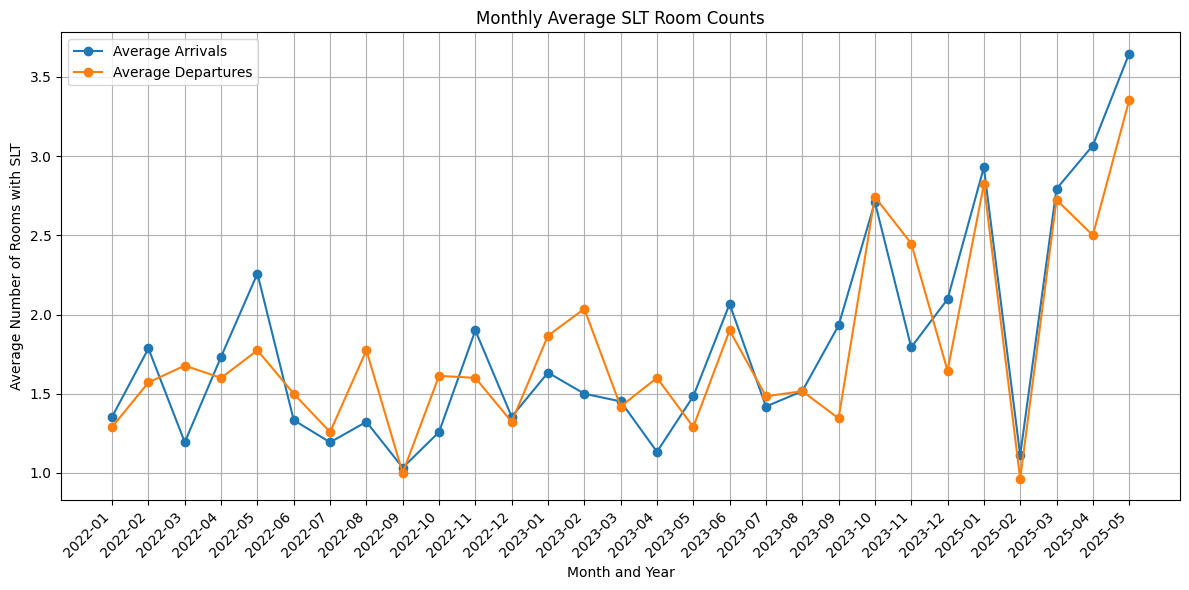

In [61]:
# --- Plot Monthly Average SLT Counts ---

# Extracting month-year labels and average counts for plotting
months = sorted(monthly_average_counts.keys())
avg_arrivals = [monthly_average_counts[month]["average_arrivals"] for month in months]
avg_departures = [monthly_average_counts[month]["average_departures"] for month in months]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(months, avg_arrivals, marker='o', label='Average Arrivals')
plt.plot(months, avg_departures, marker='o', label='Average Departures')

# Add labels and title
plt.xlabel('Month and Year')
plt.ylabel('Average Number of Rooms with SLT')
plt.title('Monthly Average SLT Room Counts')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.grid(True) # Add a grid for better readability

# Show the plot
plt.show()

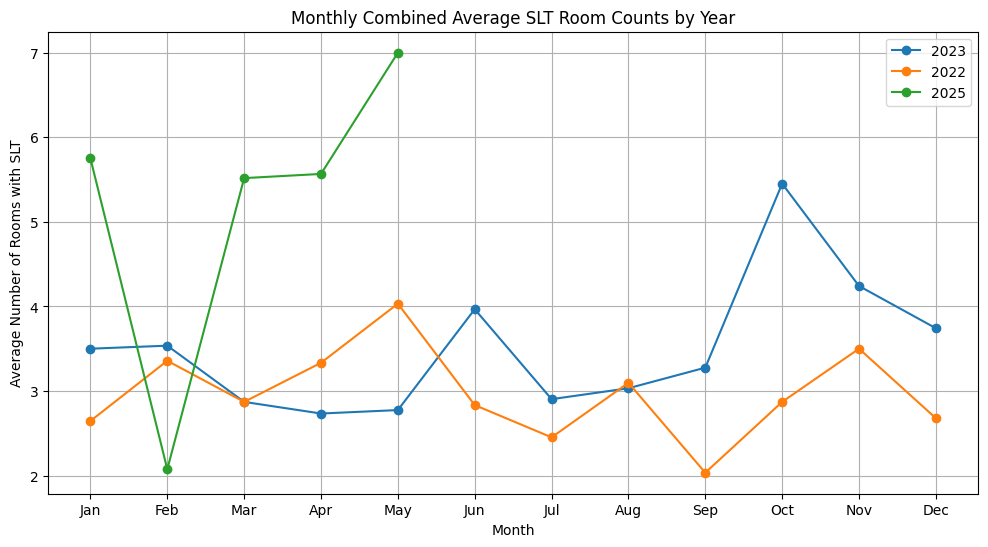

In [64]:
# --- Plot Yearly Combined Average SLT Counts by Month (Overlayed) ---

# Aggregate combined monthly averages by year (same as before)
yearly_monthly_combined_averages = {}

for month_year_key, averages in monthly_average_counts.items():
    year, month = map(int, month_year_key.split('-'))
    combined_avg = averages['average_arrivals'] + averages['average_departures']

    if year not in yearly_monthly_combined_averages:
        yearly_monthly_combined_averages[year] = {}

    yearly_monthly_combined_averages[year][month] = combined_avg

# Create a single plot
plt.figure(figsize=(12, 6))

# Plot data for each year on the same figure
for year, monthly_data in yearly_monthly_combined_averages.items():
    # Sort months and extract combined averages
    sorted_months = sorted(monthly_data.keys())
    combined_averages = [monthly_data[month] for month in sorted_months]

    # Plot the data for the current year
    plt.plot(sorted_months, combined_averages, marker='o', label=f'{year}')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Average Number of Rooms with SLT')
plt.title('Monthly Combined Average SLT Room Counts by Year')
plt.xticks(range(1, 13), [calendar.month_abbr[i] for i in range(1, 13)]) # Set x-axis ticks to month abbreviations
plt.legend()
plt.grid(True) # Add a grid for better readability

# Show the single plot
plt.show()